# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count', 'synonyms_count',
                  'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

## 2 Susceptibility in absolute and sentence-relative values

Build our data.

In [3]:
model = Model(time=Time.discrete, source=Source.all, past=Past.last_bin, durl=Durl.exclude_past, max_distance=2)
data = []

with session_scope() as session:
    substitutions = session.query(Substitution.id).filter(Substitution.model == model)
    print("Got {} substitutions for model {}".format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        # Prepare these arrays for stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        
        for feature in Substitution.__features__:
            sentence_values, _ = substitution.source_destination_features(feature)
            sentence_values_rel, _ = substitution.source_destination_features(
                feature, sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            # Stopword-check the arrays.
            words = getattr(substitution.source, source_type)[dslice]
            for i, (word, lemma, token, tag) in enumerate(zip(words, lemmas, tokens, tags)):
                if (token in stopwords) or (lemma in stopwords):
                    # Drop stopwords from this analysis since we exclude stopword-substitutions.
                    continue
                data.append({'cluster_id': substitution.source.cluster.sid,
                             'destination_id': substitution.destination.sid,
                             'occurrence': substitution.occurrence,
                             'source_id': substitution.source.sid,
                             'feature': feature,
                             'word': word,
                             'POS': tag,
                             'target': i == substitution.position,
                             'value': sentence_values[i],
                             'value_rel': sentence_values_rel[i]})

original_susties = pd.DataFrame(data)
del data

Got 8978 substitutions for model Model(time=Time.discrete, source=Source.all, past=Past.last_bin, durl=Durl.exclude_past, max_distance=2)


  0% (   1 of 8978) |                     | Elapsed Time: 0:00:04 ETA:  11:39:42

  0% (  89 of 8978) |                      | Elapsed Time: 0:00:05 ETA:  0:01:37

  1% ( 113 of 8978) |                      | Elapsed Time: 0:00:05 ETA:  0:01:35

  2% ( 188 of 8978) |                      | Elapsed Time: 0:00:06 ETA:  0:01:42

  2% ( 225 of 8978) |                      | Elapsed Time: 0:00:07 ETA:  0:01:38

  3% ( 311 of 8978) |                      | Elapsed Time: 0:00:08 ETA:  0:01:37

  3% ( 337 of 8978) |                      | Elapsed Time: 0:00:08 ETA:  0:01:37

  5% ( 449 of 8978) |#                     | Elapsed Time: 0:00:09 ETA:  0:01:33

  6% ( 562 of 8978) |#                     | Elapsed Time: 0:00:10 ETA:  0:01:28

  7% ( 638 of 8978) |#                     | Elapsed Time: 0:00:11 ETA:  0:01:30

  7% ( 674 of 8978) |#                     | Elapsed Time: 0:00:12 ETA:  0:01:28

  8% ( 745 of 8978) |#                     | Elapsed Time: 0:00:13 ETA:  0:01:32

  8% ( 786 of 8978) |#                     | Elapsed Time: 0:00:13 ETA:  0:01:33

 10% ( 898 of 8978) |##                    | Elapsed Time: 0:00:15 ETA:  0:01:30

 10% ( 979 of 8978) |##                    | Elapsed Time: 0:00:16 ETA:  0:01:31

 11% (1011 of 8978) |##                    | Elapsed Time: 0:00:16 ETA:  0:01:34

 12% (1123 of 8978) |##                    | Elapsed Time: 0:00:17 ETA:  0:01:27

 13% (1235 of 8978) |###                   | Elapsed Time: 0:00:18 ETA:  0:01:21

 14% (1323 of 8978) |###                   | Elapsed Time: 0:00:19 ETA:  0:01:19

 15% (1347 of 8978) |###                   | Elapsed Time: 0:00:20 ETA:  0:01:20

 16% (1459 of 8978) |###                   | Elapsed Time: 0:00:21 ETA:  0:01:15

 17% (1572 of 8978) |###                   | Elapsed Time: 0:00:22 ETA:  0:01:14

 18% (1627 of 8978) |###                   | Elapsed Time: 0:00:23 ETA:  0:01:21

 18% (1684 of 8978) |####                  | Elapsed Time: 0:00:24 ETA:  0:01:24

 19% (1769 of 8978) |####                  | Elapsed Time: 0:00:25 ETA:  0:01:23

 20% (1796 of 8978) |####                  | Elapsed Time: 0:00:25 ETA:  0:01:23

 20% (1875 of 8978) |####                  | Elapsed Time: 0:00:26 ETA:  0:01:23

 21% (1908 of 8978) |####                  | Elapsed Time: 0:00:27 ETA:  0:01:26

 22% (1999 of 8978) |####                  | Elapsed Time: 0:00:28 ETA:  0:01:24

 22% (2021 of 8978) |####                  | Elapsed Time: 0:00:28 ETA:  0:01:27

 23% (2133 of 8978) |#####                 | Elapsed Time: 0:00:29 ETA:  0:01:15

 25% (2245 of 8978) |#####                 | Elapsed Time: 0:00:30 ETA:  0:01:07

 25% (2332 of 8978) |#####                 | Elapsed Time: 0:00:31 ETA:  0:01:07

 26% (2357 of 8978) |#####                 | Elapsed Time: 0:00:31 ETA:  0:01:04

 27% (2449 of 8978) |######                | Elapsed Time: 0:00:32 ETA:  0:01:03

 27% (2469 of 8978) |######                | Elapsed Time: 0:00:33 ETA:  0:01:02

 28% (2562 of 8978) |######                | Elapsed Time: 0:00:34 ETA:  0:01:01

 28% (2582 of 8978) |######                | Elapsed Time: 0:00:34 ETA:  0:01:04

 30% (2694 of 8978) |######                | Elapsed Time: 0:00:35 ETA:  0:01:03

 30% (2773 of 8978) |######                | Elapsed Time: 0:00:36 ETA:  0:01:05

 31% (2806 of 8978) |######                | Elapsed Time: 0:00:36 ETA:  0:01:04

 32% (2889 of 8978) |#######               | Elapsed Time: 0:00:37 ETA:  0:01:04

 32% (2918 of 8978) |#######               | Elapsed Time: 0:00:38 ETA:  0:01:04

 33% (3031 of 8978) |#######               | Elapsed Time: 0:00:39 ETA:  0:01:02

 34% (3116 of 8978) |#######               | Elapsed Time: 0:00:40 ETA:  0:01:01

 35% (3143 of 8978) |#######               | Elapsed Time: 0:00:40 ETA:  0:01:00

 36% (3255 of 8978) |#######               | Elapsed Time: 0:00:41 ETA:  0:00:54

 37% (3363 of 8978) |########              | Elapsed Time: 0:00:42 ETA:  0:00:51

 37% (3367 of 8978) |########              | Elapsed Time: 0:00:43 ETA:  0:00:55

 38% (3450 of 8978) |########              | Elapsed Time: 0:00:44 ETA:  0:00:56

 38% (3479 of 8978) |########              | Elapsed Time: 0:00:44 ETA:  0:00:58

 40% (3592 of 8978) |########              | Elapsed Time: 0:00:45 ETA:  0:00:52

 41% (3704 of 8978) |#########             | Elapsed Time: 0:00:46 ETA:  0:00:54

 42% (3795 of 8978) |#########             | Elapsed Time: 0:00:47 ETA:  0:00:53

 42% (3816 of 8978) |#########             | Elapsed Time: 0:00:48 ETA:  0:00:56

 43% (3928 of 8978) |#########             | Elapsed Time: 0:00:49 ETA:  0:00:44

 45% (4041 of 8978) |#########             | Elapsed Time: 0:00:50 ETA:  0:00:45

 45% (4129 of 8978) |##########            | Elapsed Time: 0:00:51 ETA:  0:00:45

 46% (4153 of 8978) |##########            | Elapsed Time: 0:00:51 ETA:  0:00:45

 47% (4233 of 8978) |##########            | Elapsed Time: 0:00:52 ETA:  0:00:47

 47% (4265 of 8978) |##########            | Elapsed Time: 0:00:53 ETA:  0:00:48

 48% (4377 of 8978) |##########            | Elapsed Time: 0:00:54 ETA:  0:00:46

 50% (4489 of 8978) |###########           | Elapsed Time: 0:00:55 ETA:  0:00:43

 51% (4602 of 8978) |###########           | Elapsed Time: 0:00:56 ETA:  0:00:39

 52% (4714 of 8978) |###########           | Elapsed Time: 0:00:57 ETA:  0:00:32

 53% (4826 of 8978) |###########           | Elapsed Time: 0:00:58 ETA:  0:00:29

 54% (4908 of 8978) |############          | Elapsed Time: 0:00:59 ETA:  0:00:31

 55% (4938 of 8978) |############          | Elapsed Time: 0:01:00 ETA:  0:00:34

 56% (5051 of 8978) |############          | Elapsed Time: 0:01:01 ETA:  0:00:32

 57% (5163 of 8978) |############          | Elapsed Time: 0:01:02 ETA:  0:00:33

 58% (5275 of 8978) |############          | Elapsed Time: 0:01:03 ETA:  0:00:32

 60% (5387 of 8978) |#############         | Elapsed Time: 0:01:04 ETA:  0:00:25

 61% (5478 of 8978) |#############         | Elapsed Time: 0:01:05 ETA:  0:00:24

 61% (5500 of 8978) |#############         | Elapsed Time: 0:01:05 ETA:  0:00:24

 62% (5612 of 8978) |#############         | Elapsed Time: 0:01:07 ETA:  0:00:31

 63% (5724 of 8978) |##############        | Elapsed Time: 0:01:08 ETA:  0:00:32

 65% (5836 of 8978) |##############        | Elapsed Time: 0:01:09 ETA:  0:00:33

 66% (5948 of 8978) |##############        | Elapsed Time: 0:01:10 ETA:  0:00:28

 67% (6061 of 8978) |##############        | Elapsed Time: 0:01:11 ETA:  0:00:17

 68% (6173 of 8978) |###############       | Elapsed Time: 0:01:12 ETA:  0:00:14

 70% (6285 of 8978) |###############       | Elapsed Time: 0:01:13 ETA:  0:00:12

 71% (6397 of 8978) |###############       | Elapsed Time: 0:01:15 ETA:  0:00:13

 72% (6489 of 8978) |###############       | Elapsed Time: 0:01:16 ETA:  0:00:13

 72% (6510 of 8978) |###############       | Elapsed Time: 0:01:16 ETA:  0:00:13

 73% (6595 of 8978) |################      | Elapsed Time: 0:01:17 ETA:  0:00:15

 73% (6622 of 8978) |################      | Elapsed Time: 0:01:17 ETA:  0:00:17

 74% (6713 of 8978) |################      | Elapsed Time: 0:01:18 ETA:  0:00:17

 75% (6734 of 8978) |################      | Elapsed Time: 0:01:18 ETA:  0:00:17

 75% (6820 of 8978) |################      | Elapsed Time: 0:01:19 ETA:  0:00:18

 76% (6846 of 8978) |################      | Elapsed Time: 0:01:20 ETA:  0:00:20

 77% (6958 of 8978) |#################     | Elapsed Time: 0:01:21 ETA:  0:00:18

 78% (7071 of 8978) |#################     | Elapsed Time: 0:01:22 ETA:  0:00:14

 79% (7151 of 8978) |#################     | Elapsed Time: 0:01:23 ETA:  0:00:16

 80% (7183 of 8978) |#################     | Elapsed Time: 0:01:23 ETA:  0:00:15

 80% (7270 of 8978) |#################     | Elapsed Time: 0:01:24 ETA:  0:00:15

 81% (7295 of 8978) |#################     | Elapsed Time: 0:01:25 ETA:  0:00:14

 82% (7407 of 8978) |##################    | Elapsed Time: 0:01:26 ETA:  0:00:11

 83% (7498 of 8978) |##################    | Elapsed Time: 0:01:27 ETA:  0:00:11

 83% (7520 of 8978) |##################    | Elapsed Time: 0:01:27 ETA:  0:00:13

 84% (7609 of 8978) |##################    | Elapsed Time: 0:01:28 ETA:  0:00:12

 85% (7632 of 8978) |##################    | Elapsed Time: 0:01:28 ETA:  0:00:09

 86% (7744 of 8978) |##################    | Elapsed Time: 0:01:29 ETA:  0:00:07

 87% (7856 of 8978) |###################   | Elapsed Time: 0:01:31 ETA:  0:00:05

 88% (7943 of 8978) |###################   | Elapsed Time: 0:01:32 ETA:  0:00:05

 88% (7968 of 8978) |###################   | Elapsed Time: 0:01:32 ETA:  0:00:05

 90% (8081 of 8978) |###################   | Elapsed Time: 0:01:33 ETA:  0:00:02

 90% (8167 of 8978) |####################  | Elapsed Time: 0:01:34 ETA:  0:00:03

 91% (8193 of 8978) |####################  | Elapsed Time: 0:01:34 ETA:  0:00:04

 92% (8281 of 8978) |####################  | Elapsed Time: 0:01:35 ETA:  0:00:04

 92% (8305 of 8978) |####################  | Elapsed Time: 0:01:36 ETA:  0:00:04

 92% (8334 of 8978) |####################  | Elapsed Time: 0:01:37 ETA:  0:00:16

 93% (8392 of 8978) |####################  | Elapsed Time: 0:01:38 ETA:  0:00:23

 93% (8417 of 8978) |####################  | Elapsed Time: 0:01:38 ETA:  0:00:25

 94% (8507 of 8978) |####################  | Elapsed Time: 0:01:39 ETA:  0:00:27

 95% (8530 of 8978) |####################  | Elapsed Time: 0:01:39 ETA:  0:00:27

 96% (8623 of 8978) |##################### | Elapsed Time: 0:01:40 ETA:  0:00:24

 96% (8642 of 8978) |##################### | Elapsed Time: 0:01:41 ETA:  0:00:23

 97% (8726 of 8978) |##################### | Elapsed Time: 0:01:42 ETA:  0:00:24

 97% (8754 of 8978) |##################### | Elapsed Time: 0:01:42 ETA:  0:00:25

 98% (8837 of 8978) |##################### | Elapsed Time: 0:01:43 ETA:  0:00:10

 98% (8866 of 8978) |##################### | Elapsed Time: 0:01:43 ETA:  0:00:04

 99% (8938 of 8978) |##################### | Elapsed Time: 0:01:44 ETA:  0:00:03

100% (8978 of 8978) |######################| Elapsed Time: 0:01:45 Time: 0:01:45


Assign proper weight to each substitution.

In [4]:
susty_words = original_susties.copy()
divide_target_sum = lambda x: x / (susty_words.loc[x.index].target *
                                   susty_words.loc[x.index].weight).sum()

# Weight is 1, at first.
susty_words['weight'] = 1
# Divided by the number of substitutions that share a durl.
susty_words['weight'] = susty_words\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_target_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_target_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
susty_words['weight'] = susty_words\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_target_sum)

# Finally, add a weight measure for word appearances that we use in the POS analysis,
# weighing a word by the number of words that appear with it in its sentence.
susty_words['weight_appeared'] = susty_words\
    .groupby(['source_id', 'destination_id', 'occurrence', 'feature'])['weight']\
    .transform(lambda x: x / len(x))

Compute susceptibility for each feature value and each feature sentence_relative value.

In [5]:
susty = lambda x: ((x * susty_words.loc[x.index, 'weight']).sum() /
                   susty_words.loc[x.index, 'weight'].sum())
susties = susty_words\
    .groupby(['feature', 'value'], as_index=False)['target']\
    .aggregate({'susty': susty})
susties_rel = susty_words\
    .groupby(['feature', 'value_rel'], as_index=False)['target']\
    .aggregate({'susty': susty})\
    .rename(columns={'value_rel': 'value'})

Bin and plot susceptibilities for each feature, in absolute value and sentence-relative.

In [6]:
def plot_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    x = data['value']
    s = data['susty']
    
    # Compute binning.
    x_bins, bins = pd.cut(x, BIN_COUNT, right=False, labels=False, retbins=True)
    middles = (bins[:-1] + bins[1:]) / 2
    
    # Compute bin values.
    heights = np.zeros(BIN_COUNT)
    cis = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = s[x_bins == i].mean()
        cis[i] = 1.96 * s[x_bins == i].std() / np.sqrt((x_bins == i).sum() - 1)
    
    # Plot.
    sigmaphi = r'\sigma_{/phi' + (',r' if relative else '') + '}'
    plt.plot(middles, heights, '-', lw=2, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, heights - cis, heights + cis,
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, .5)

### 2.1 All feature susceptibilities

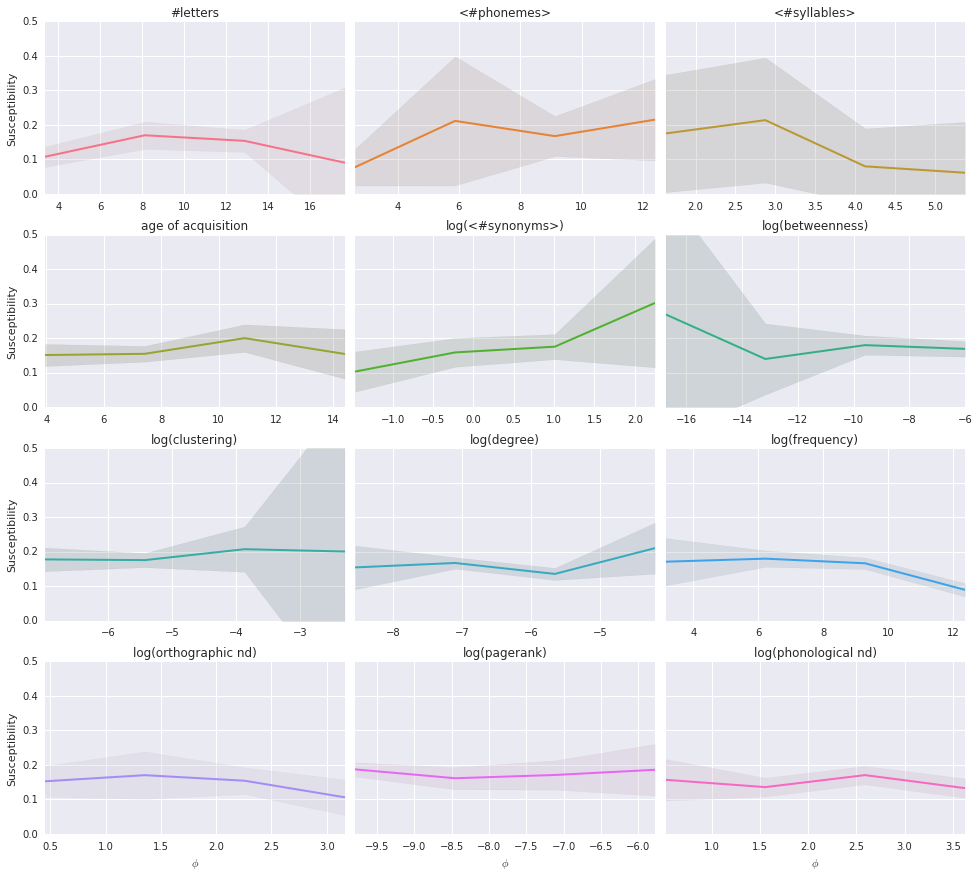

In [7]:
ordered_features = sorted(Substitution.__features__,
                          key=lambda f: Substitution._transformed_feature(f).__doc__)
g = sb.FacetGrid(data=susties, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

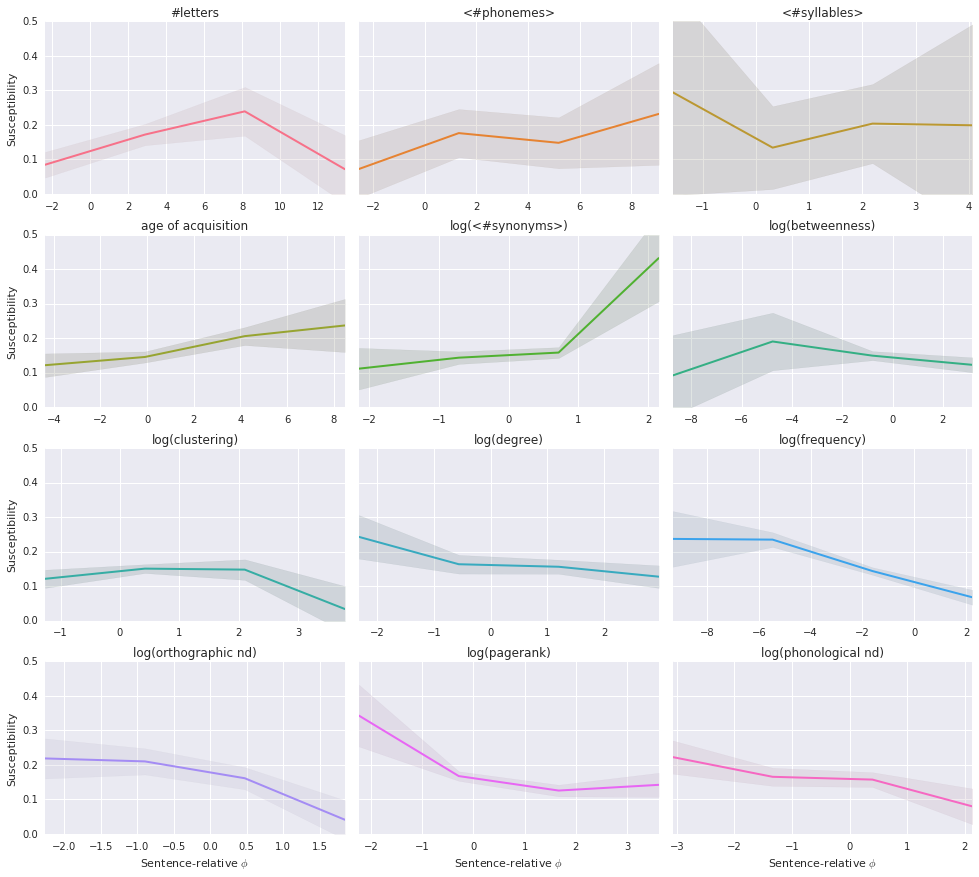

In [8]:
g = sb.FacetGrid(data=susties_rel, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on how confidence intervals are computed here**

There are three ways I can conceive of the computation represented in the graphs above:
1. For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.
2. Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. This is the way CIs are computed above.
3. Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values. So for now I'm sticking with (2).

### 2.2 Feature susceptibilities, reduced to features we expose in the paper

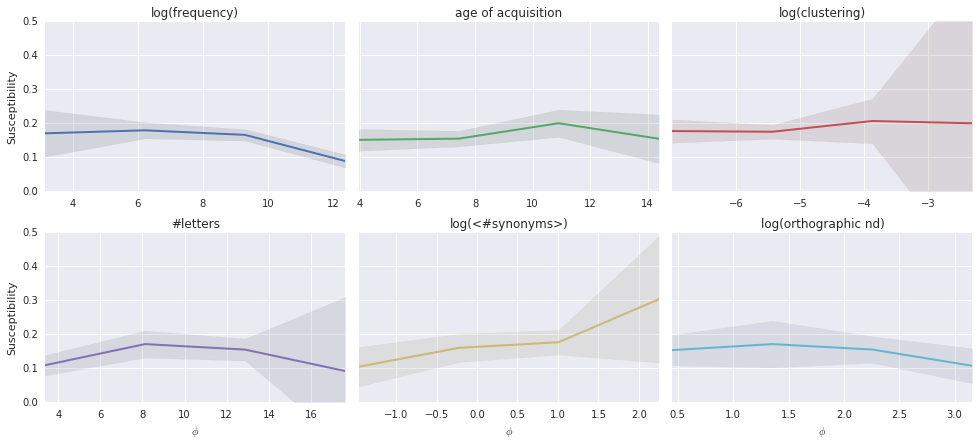

In [9]:
g = sb.FacetGrid(data=susties[susties['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

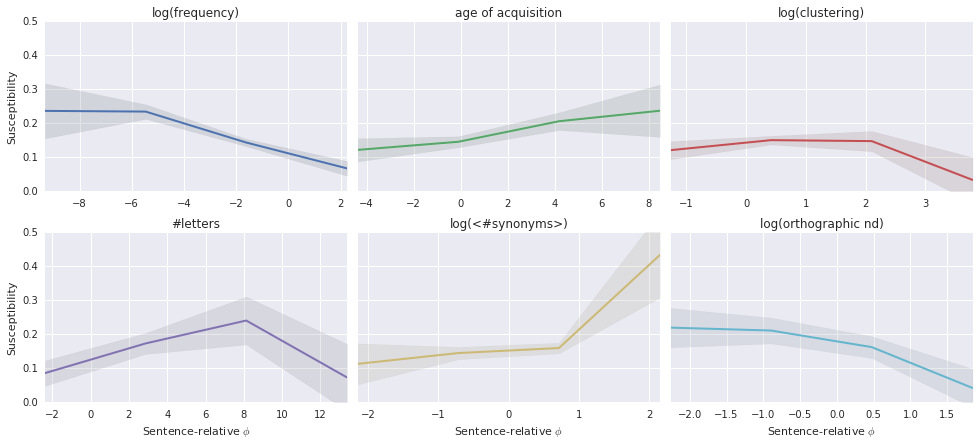

In [10]:
g = sb.FacetGrid(data=susties_rel[susties_rel['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

## 3 On which POS tags do substitutions fall?

In [11]:
poses = susty_words[susty_words.feature == 'aoa'][['POS', 'cluster_id', 'destination_id',
                                                   'occurrence', 'source_id', 'target',
                                                   'weight', 'weight_appeared', 'word']]
# Only take first letter of POS code to denote categories,
# and group stopword-like categories together.
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']
poses['rPOS'] = poses['POS']\
    .apply(lambda x: x[0])\
    .apply(lambda x: 'Stopword-like' if x in stop_poses else x)

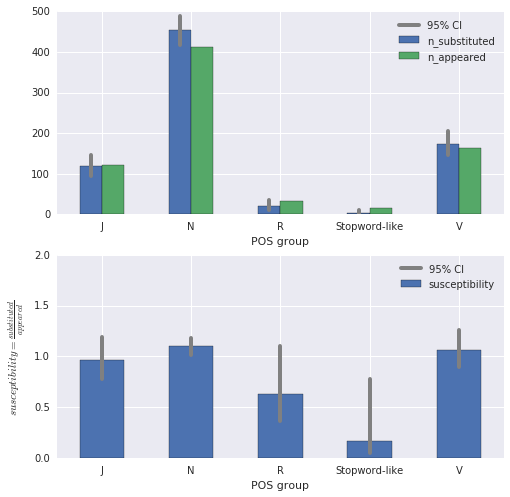

In [12]:
# Compute POS counts.
susty_pos = lambda x: ((x * poses.loc[x.index, 'weight']).sum() /
                       poses.loc[x.index, 'weight_appeared'].sum())
susties_pos = poses.groupby('rPOS')['target'].aggregate(
    {'susceptibility': susty_pos,
     'n_substituted': lambda x: (x * poses.loc[x.index, 'weight']).sum(),
     'n_appeared': lambda x: poses.loc[x.index, 'weight_appeared'].sum()}
).rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']].plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(), method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted, lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility'].plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], cis[i] * total_substituted / susties_pos.n_appeared.iloc[i],
                 lw=4, color='grey', label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-pos_susceptibilities'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [13]:
# Test the n_substituted proportions are different from the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['N', 'R', 'Stopword-like']


## 4 Susceptibility in terms of absolute fractiles

In [14]:
def plot_absolute_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')

    # Compute feature bins.
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            x_fractiles = pd.qcut(data.value, bin_count, labels=False)
            break
        except ValueError:
            pass

    # Compute bin counts
    heights = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = data[data.target & (x_fractiles == i)].weight.sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, bin_count + 1), heights, color=color)
    plt.fill_between(range(1, bin_count + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, bin_count + 1))
    plt.xlim(1, bin_count)
    plt.ylim(0, None)

### 4.1 All features susceptibilities

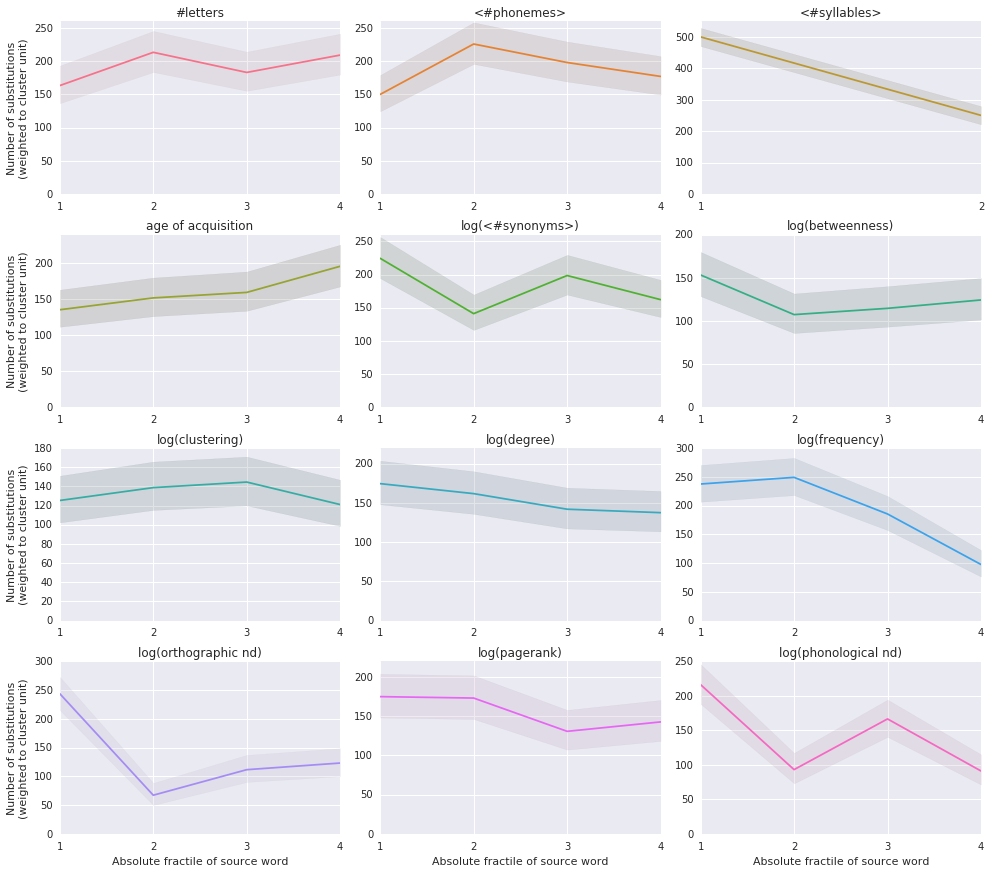

In [15]:
# Now plot.
g = sb.FacetGrid(data=susty_words, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're again in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all absolute feature fractiles are available to sample from in all the sentences. Again, there's no way out of this, so we're going to use multinomial CIs.

### 4.2 Feature susceptibilities, reduced to features we expose in the paper

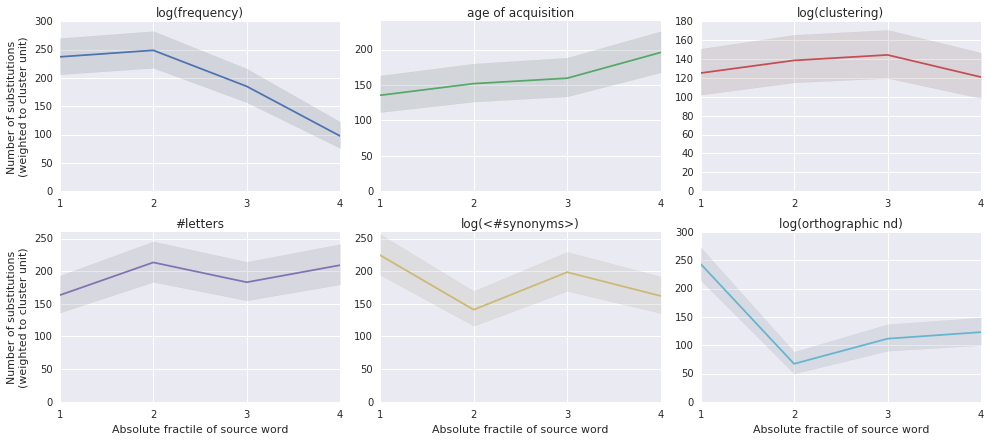

In [16]:
# Now plot.
g = sb.FacetGrid(data=susty_words[susty_words['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

## 5 Susceptibility in terms of sentence fractiles

Build our data.

In [17]:
data = []
for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for feature in Substitution.__features__:
            source, _ = substitution.features(feature)
            if np.isnan(source):
                # The source word has no feature value. We drop this substitution.
                continue
            sentence, _ = substitution.source_destination_features(feature)
            # Remove stopwords from this analysis, since we dropped substitutions on stopwords.
            dslice = slice(substitution.start,
                           substitution.start + len(substitution.destination.tokens))
            is_stopword = np.array([(lemma in stopwords) or (token in stopwords)
                                    for (lemma, token) in
                                    zip(substitution.source.lemmas[dslice],
                                        substitution.source.tokens[dslice])])
            sentence[is_stopword] = np.nan
            # Find the number of bins we'll use.
            values = set(sentence[np.isfinite(sentence)])
            if len(values) == 0 or len(values) == 1:
                # Only NaNs, or only one feature value. Drop this.
                continue
            start, stop = None, None
            power = 0
            while start is None:
                if int(BIN_COUNT / 2**power) * 2**power != BIN_COUNT:
                    raise ValueError('BIN_COUNT must be a power of 2')
                try:
                    start = 2**power * pd.qcut(sentence, int(BIN_COUNT / 2**power),
                                               labels=False)[substitution.position]
                    stop = start + 2**power
                except ValueError:
                    power += 1
            # And finally save the bin.
            data.append({'cluster_id': substitution.source.cluster.sid,
                         'destination_id': substitution.destination.sid,
                         'occurrence': substitution.occurrence,
                         'source_id': substitution.source.sid,
                         'feature': feature,
                         'start': start,
                         'stop': stop})

original_fractiles = pd.DataFrame(data)
del data

  0% (  71 of 8978) |                      | Elapsed Time: 0:00:01 ETA:  0:02:05

  1% ( 113 of 8978) |                      | Elapsed Time: 0:00:01 ETA:  0:02:19

  2% ( 186 of 8978) |                      | Elapsed Time: 0:00:02 ETA:  0:02:07

  2% ( 225 of 8978) |                      | Elapsed Time: 0:00:03 ETA:  0:02:04

  3% ( 308 of 8978) |                      | Elapsed Time: 0:00:04 ETA:  0:01:57

  3% ( 337 of 8978) |                      | Elapsed Time: 0:00:04 ETA:  0:01:57

  4% ( 420 of 8978) |#                     | Elapsed Time: 0:00:05 ETA:  0:01:53

  5% ( 449 of 8978) |#                     | Elapsed Time: 0:00:06 ETA:  0:01:54

  5% ( 526 of 8978) |#                     | Elapsed Time: 0:00:07 ETA:  0:01:52

  6% ( 562 of 8978) |#                     | Elapsed Time: 0:00:07 ETA:  0:01:51

  7% ( 640 of 8978) |#                     | Elapsed Time: 0:00:08 ETA:  0:01:48

  7% ( 674 of 8978) |#                     | Elapsed Time: 0:00:09 ETA:  0:01:47

  8% ( 786 of 8978) |#                     | Elapsed Time: 0:00:10 ETA:  0:01:41

  9% ( 869 of 8978) |##                    | Elapsed Time: 0:00:11 ETA:  0:01:38

 10% ( 898 of 8978) |##                    | Elapsed Time: 0:00:11 ETA:  0:01:39

 10% ( 976 of 8978) |##                    | Elapsed Time: 0:00:12 ETA:  0:01:37

 11% (1011 of 8978) |##                    | Elapsed Time: 0:00:12 ETA:  0:01:35

 12% (1097 of 8978) |##                    | Elapsed Time: 0:00:13 ETA:  0:01:33

 12% (1123 of 8978) |##                    | Elapsed Time: 0:00:14 ETA:  0:01:32

 13% (1206 of 8978) |##                    | Elapsed Time: 0:00:15 ETA:  0:01:30

 13% (1235 of 8978) |###                   | Elapsed Time: 0:00:15 ETA:  0:01:33

 14% (1316 of 8978) |###                   | Elapsed Time: 0:00:16 ETA:  0:01:32

 15% (1347 of 8978) |###                   | Elapsed Time: 0:00:17 ETA:  0:01:33

 15% (1410 of 8978) |###                   | Elapsed Time: 0:00:18 ETA:  0:01:35

 16% (1459 of 8978) |###                   | Elapsed Time: 0:00:18 ETA:  0:01:36

 17% (1528 of 8978) |###                   | Elapsed Time: 0:00:19 ETA:  0:01:39

 17% (1572 of 8978) |###                   | Elapsed Time: 0:00:20 ETA:  0:01:42

 18% (1644 of 8978) |####                  | Elapsed Time: 0:00:21 ETA:  0:01:41

 18% (1684 of 8978) |####                  | Elapsed Time: 0:00:21 ETA:  0:01:41

 19% (1761 of 8978) |####                  | Elapsed Time: 0:00:22 ETA:  0:01:41

 20% (1796 of 8978) |####                  | Elapsed Time: 0:00:23 ETA:  0:01:43

 20% (1874 of 8978) |####                  | Elapsed Time: 0:00:24 ETA:  0:01:41

 21% (1908 of 8978) |####                  | Elapsed Time: 0:00:24 ETA:  0:01:38

 22% (1991 of 8978) |####                  | Elapsed Time: 0:00:25 ETA:  0:01:34

 22% (2021 of 8978) |####                  | Elapsed Time: 0:00:26 ETA:  0:01:31

 23% (2133 of 8978) |#####                 | Elapsed Time: 0:00:27 ETA:  0:01:22

 25% (2245 of 8978) |#####                 | Elapsed Time: 0:00:28 ETA:  0:01:15

 26% (2341 of 8978) |#####                 | Elapsed Time: 0:00:29 ETA:  0:01:10

 26% (2357 of 8978) |#####                 | Elapsed Time: 0:00:29 ETA:  0:01:09

 27% (2428 of 8978) |#####                 | Elapsed Time: 0:00:30 ETA:  0:01:10

 27% (2469 of 8978) |######                | Elapsed Time: 0:00:31 ETA:  0:01:11

 28% (2539 of 8978) |######                | Elapsed Time: 0:00:32 ETA:  0:01:14

 28% (2582 of 8978) |######                | Elapsed Time: 0:00:32 ETA:  0:01:15

 29% (2672 of 8978) |######                | Elapsed Time: 0:00:33 ETA:  0:01:13

 30% (2694 of 8978) |######                | Elapsed Time: 0:00:34 ETA:  0:01:17

 30% (2764 of 8978) |######                | Elapsed Time: 0:00:35 ETA:  0:01:19

 31% (2806 of 8978) |######                | Elapsed Time: 0:00:35 ETA:  0:01:22

 32% (2893 of 8978) |#######               | Elapsed Time: 0:00:36 ETA:  0:01:19

 32% (2918 of 8978) |#######               | Elapsed Time: 0:00:36 ETA:  0:01:17

 33% (2999 of 8978) |#######               | Elapsed Time: 0:00:37 ETA:  0:01:14

 33% (3031 of 8978) |#######               | Elapsed Time: 0:00:38 ETA:  0:01:11

 34% (3107 of 8978) |#######               | Elapsed Time: 0:00:39 ETA:  0:01:12

 35% (3143 of 8978) |#######               | Elapsed Time: 0:00:39 ETA:  0:01:15

 35% (3217 of 8978) |#######               | Elapsed Time: 0:00:40 ETA:  0:01:15

 36% (3255 of 8978) |#######               | Elapsed Time: 0:00:41 ETA:  0:01:13

 37% (3340 of 8978) |########              | Elapsed Time: 0:00:42 ETA:  0:01:11

 37% (3367 of 8978) |########              | Elapsed Time: 0:00:42 ETA:  0:01:13

 38% (3447 of 8978) |########              | Elapsed Time: 0:00:43 ETA:  0:01:11

 38% (3457 of 8978) |########              | Elapsed Time: 0:00:44 ETA:  0:01:28

 38% (3479 of 8978) |########              | Elapsed Time: 0:00:45 ETA:  0:01:28

 40% (3592 of 8978) |########              | Elapsed Time: 0:00:46 ETA:  0:01:20

 40% (3655 of 8978) |########              | Elapsed Time: 0:00:47 ETA:  0:01:22

 41% (3704 of 8978) |#########             | Elapsed Time: 0:00:48 ETA:  0:01:25

 42% (3774 of 8978) |#########             | Elapsed Time: 0:00:49 ETA:  0:01:29

 42% (3816 of 8978) |#########             | Elapsed Time: 0:00:49 ETA:  0:01:26

 43% (3904 of 8978) |#########             | Elapsed Time: 0:00:50 ETA:  0:01:23

 43% (3928 of 8978) |#########             | Elapsed Time: 0:00:50 ETA:  0:01:05

 44% (4013 of 8978) |#########             | Elapsed Time: 0:00:51 ETA:  0:01:02

 45% (4041 of 8978) |#########             | Elapsed Time: 0:00:52 ETA:  0:01:08

 46% (4153 of 8978) |##########            | Elapsed Time: 0:00:53 ETA:  0:00:56

 47% (4230 of 8978) |##########            | Elapsed Time: 0:00:54 ETA:  0:00:52

 47% (4265 of 8978) |##########            | Elapsed Time: 0:00:54 ETA:  0:00:48

 48% (4377 of 8978) |##########            | Elapsed Time: 0:00:55 ETA:  0:00:44

 49% (4468 of 8978) |##########            | Elapsed Time: 0:00:56 ETA:  0:00:43

 50% (4489 of 8978) |###########           | Elapsed Time: 0:00:57 ETA:  0:00:42

 50% (4573 of 8978) |###########           | Elapsed Time: 0:00:58 ETA:  0:00:40

 51% (4602 of 8978) |###########           | Elapsed Time: 0:00:58 ETA:  0:00:45

 52% (4680 of 8978) |###########           | Elapsed Time: 0:00:59 ETA:  0:00:45

 52% (4714 of 8978) |###########           | Elapsed Time: 0:00:59 ETA:  0:00:42

 53% (4826 of 8978) |###########           | Elapsed Time: 0:01:00 ETA:  0:00:40

 54% (4904 of 8978) |############          | Elapsed Time: 0:01:01 ETA:  0:00:41

 55% (4938 of 8978) |############          | Elapsed Time: 0:01:02 ETA:  0:00:44

 55% (5007 of 8978) |############          | Elapsed Time: 0:01:03 ETA:  0:00:47

 56% (5051 of 8978) |############          | Elapsed Time: 0:01:04 ETA:  0:00:46

 57% (5135 of 8978) |############          | Elapsed Time: 0:01:05 ETA:  0:00:45

 57% (5163 of 8978) |############          | Elapsed Time: 0:01:05 ETA:  0:00:45

 58% (5246 of 8978) |############          | Elapsed Time: 0:01:06 ETA:  0:00:45

 58% (5275 of 8978) |############          | Elapsed Time: 0:01:06 ETA:  0:00:49

 59% (5355 of 8978) |#############         | Elapsed Time: 0:01:07 ETA:  0:00:48

 60% (5387 of 8978) |#############         | Elapsed Time: 0:01:08 ETA:  0:00:48

 61% (5483 of 8978) |#############         | Elapsed Time: 0:01:09 ETA:  0:00:42

 61% (5500 of 8978) |#############         | Elapsed Time: 0:01:09 ETA:  0:00:39

 62% (5595 of 8978) |#############         | Elapsed Time: 0:01:10 ETA:  0:00:35

 62% (5612 of 8978) |#############         | Elapsed Time: 0:01:10 ETA:  0:00:36

 63% (5684 of 8978) |#############         | Elapsed Time: 0:01:11 ETA:  0:00:36

 63% (5724 of 8978) |##############        | Elapsed Time: 0:01:12 ETA:  0:00:36

 64% (5803 of 8978) |##############        | Elapsed Time: 0:01:13 ETA:  0:00:36

 65% (5836 of 8978) |##############        | Elapsed Time: 0:01:13 ETA:  0:00:36

 65% (5915 of 8978) |##############        | Elapsed Time: 0:01:14 ETA:  0:00:35

 66% (5948 of 8978) |##############        | Elapsed Time: 0:01:15 ETA:  0:00:40

 67% (6042 of 8978) |##############        | Elapsed Time: 0:01:16 ETA:  0:00:36

 67% (6061 of 8978) |##############        | Elapsed Time: 0:01:16 ETA:  0:00:39

 68% (6173 of 8978) |###############       | Elapsed Time: 0:01:17 ETA:  0:00:30

 69% (6252 of 8978) |###############       | Elapsed Time: 0:01:18 ETA:  0:00:28

 70% (6285 of 8978) |###############       | Elapsed Time: 0:01:18 ETA:  0:00:27

 70% (6366 of 8978) |###############       | Elapsed Time: 0:01:19 ETA:  0:00:25

 71% (6397 of 8978) |###############       | Elapsed Time: 0:01:20 ETA:  0:00:23

 72% (6477 of 8978) |###############       | Elapsed Time: 0:01:21 ETA:  0:00:21

 72% (6510 of 8978) |###############       | Elapsed Time: 0:01:21 ETA:  0:00:22

 73% (6589 of 8978) |################      | Elapsed Time: 0:01:22 ETA:  0:00:23

 73% (6622 of 8978) |################      | Elapsed Time: 0:01:23 ETA:  0:00:25

 75% (6734 of 8978) |################      | Elapsed Time: 0:01:24 ETA:  0:00:19

 75% (6822 of 8978) |################      | Elapsed Time: 0:01:25 ETA:  0:00:17

 76% (6846 of 8978) |################      | Elapsed Time: 0:01:25 ETA:  0:00:15

 77% (6938 of 8978) |#################     | Elapsed Time: 0:01:26 ETA:  0:00:14

 77% (6958 of 8978) |#################     | Elapsed Time: 0:01:26 ETA:  0:00:12

 78% (7049 of 8978) |#################     | Elapsed Time: 0:01:27 ETA:  0:00:10

 78% (7071 of 8978) |#################     | Elapsed Time: 0:01:27 ETA:  0:00:09

 79% (7155 of 8978) |#################     | Elapsed Time: 0:01:28 ETA:  0:00:09

 80% (7183 of 8978) |#################     | Elapsed Time: 0:01:29 ETA:  0:00:13

 81% (7274 of 8978) |#################     | Elapsed Time: 0:01:30 ETA:  0:00:12

 81% (7295 of 8978) |#################     | Elapsed Time: 0:01:30 ETA:  0:00:12

 82% (7407 of 8978) |##################    | Elapsed Time: 0:01:31 ETA:  0:00:09

 83% (7495 of 8978) |##################    | Elapsed Time: 0:01:32 ETA:  0:00:08

 83% (7520 of 8978) |##################    | Elapsed Time: 0:01:33 ETA:  0:00:09

 84% (7604 of 8978) |##################    | Elapsed Time: 0:01:34 ETA:  0:00:08

 85% (7632 of 8978) |##################    | Elapsed Time: 0:01:34 ETA:  0:00:06

 85% (7712 of 8978) |##################    | Elapsed Time: 0:01:35 ETA:  0:00:06

 86% (7744 of 8978) |##################    | Elapsed Time: 0:01:35 ETA:  0:00:06

 87% (7823 of 8978) |###################   | Elapsed Time: 0:01:36 ETA:  0:00:07

 87% (7856 of 8978) |###################   | Elapsed Time: 0:01:37 ETA:  0:00:09

 88% (7935 of 8978) |###################   | Elapsed Time: 0:01:38 ETA:  0:00:10

 88% (7968 of 8978) |###################   | Elapsed Time: 0:01:38 ETA:  0:00:11

 89% (8054 of 8978) |###################   | Elapsed Time: 0:01:39 ETA:  0:00:09

 90% (8081 of 8978) |###################   | Elapsed Time: 0:01:39 ETA:  0:00:08

 90% (8168 of 8978) |####################  | Elapsed Time: 0:01:40 ETA:  0:00:07

 91% (8193 of 8978) |####################  | Elapsed Time: 0:01:41 ETA:  0:00:06

 92% (8282 of 8978) |####################  | Elapsed Time: 0:01:42 ETA:  0:00:04

 92% (8305 of 8978) |####################  | Elapsed Time: 0:01:42 ETA:  0:00:03

 93% (8389 of 8978) |####################  | Elapsed Time: 0:01:43 ETA:  0:00:03

 93% (8417 of 8978) |####################  | Elapsed Time: 0:01:43 ETA:  0:00:01

 94% (8499 of 8978) |####################  | Elapsed Time: 0:01:44 ETA:  0:00:00

 95% (8530 of 8978) |####################  | Elapsed Time: 0:01:45 ETA:  0:00:01

 95% (8612 of 8978) |##################### | Elapsed Time: 0:01:46 ETA:  0:00:01

 96% (8642 of 8978) |##################### | Elapsed Time: 0:01:46 ETA:  0:00:02

 97% (8724 of 8978) |##################### | Elapsed Time: 0:01:47 ETA:  0:00:02

 97% (8754 of 8978) |##################### | Elapsed Time: 0:01:47 ETA:  0:00:03

 98% (8866 of 8978) |##################### | Elapsed Time: 0:01:49 ETA:  0:00:00

 99% (8951 of 8978) |##################### | Elapsed Time: 0:01:50 ETA:  0:00:00

100% (8978 of 8978) |######################| Elapsed Time: 0:01:50 Time: 0:01:50


Compute the weight of each substitution, according to what other substitutions it's pooled with, and the size of its bin. Letting:
* $n_d(i) = \#\text{substitutions with same durl as substitution }i$
* and $n_c(i) = \#\text{substitutions with same cluster as substitution }i$ (counting substitutions with the same durl as one)
* $p(i) = \text{precision (width) of the bin we assigned to substitution }i$

Then we define the weight of a substitution $i$:
$$w(i) = \frac{1}{n_d(i) n_c(i) p(i)}$$

In [18]:
fractiles = original_fractiles.copy()
divide_sum = lambda x: x / x.sum()

# Weight is 1 at first.
fractiles['weight'] = 1
# Divided by the number of substitutions that share a durl.
fractiles['weight'] = fractiles\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
fractiles['weight'] = fractiles\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_sum)
# And finally divide by the precision of the bin we put a substitution in.
fractiles['weight'] = fractiles['weight'] / (fractiles['stop'] - fractiles['start'])

Now for each feature, count the sum of weights in each bin and plot that.

In [19]:
def plot_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = data[(data['start'] <= i) & (i < data['stop'])]['weight'].sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, BIN_COUNT + 1), heights, color=color)
    plt.fill_between(range(1, BIN_COUNT + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, BIN_COUNT + 1))
    plt.ylim(0, None)

### 5.1 All features susceptibilities

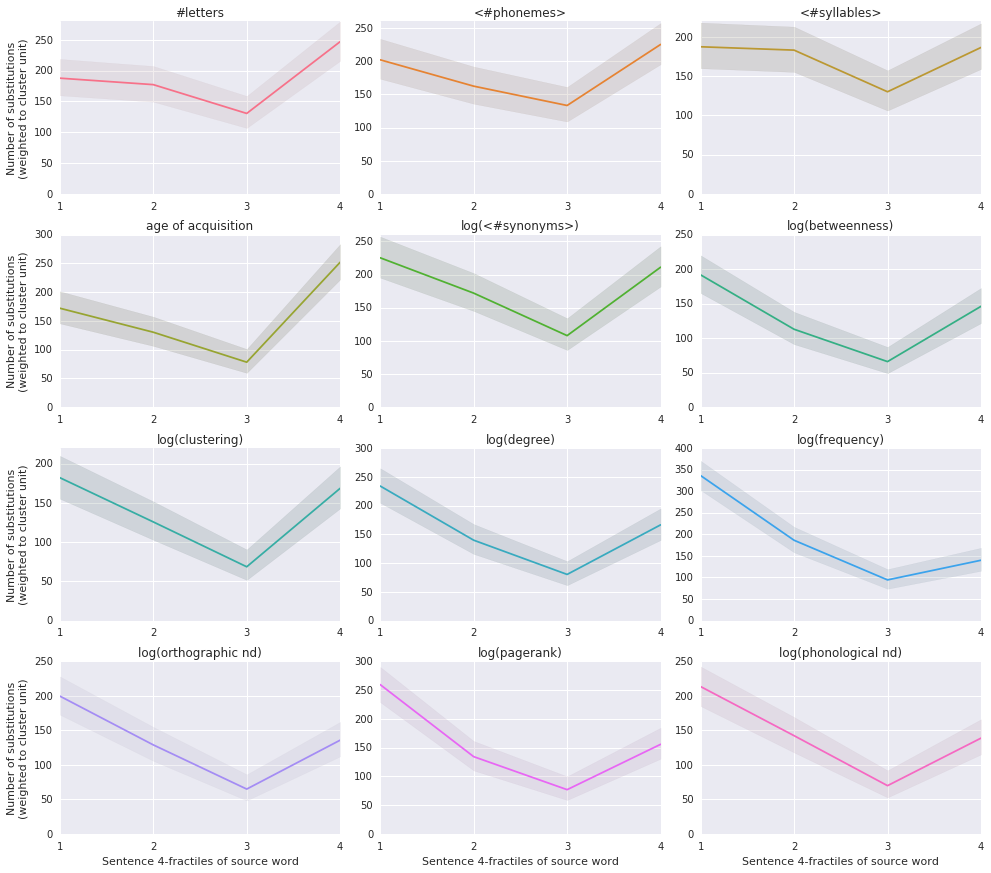

In [20]:
# Now plot.
g = sb.FacetGrid(data=fractiles, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're finally in a real multinomial sampling (and it's the only time). So we're going to use multinomial CIs.

### 5.2 Feature susceptibilities, reduced to features we expose in the paper

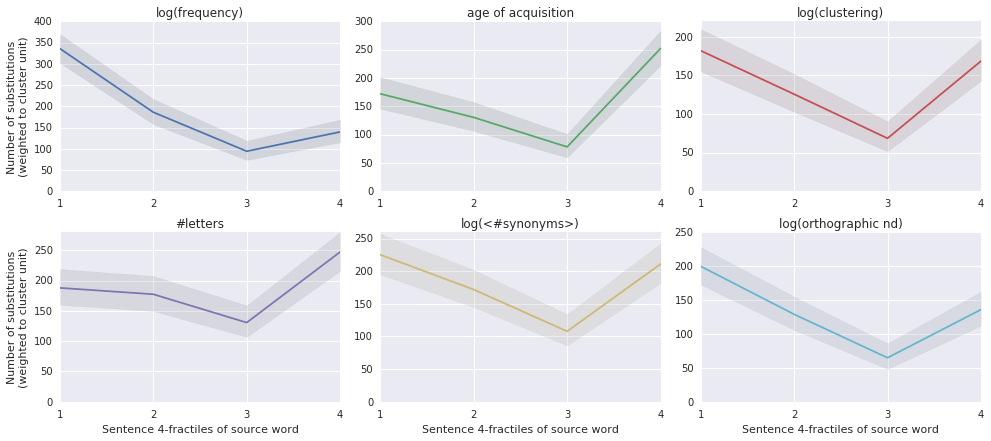

In [21]:
# Now plot.
g = sb.FacetGrid(data=fractiles[fractiles['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)